### Tests
Use of the agglomerative clustering with HR diagram.

We test here metrics to detect good solutions for clustering

In [1]:
import sys, os
sys.path.append('../../src')

from numba import jit

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle

from math import ceil
import math
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from astroML.correlation import two_point
from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 9, 6
###################################

clustername = "NGC 1647"
# voname = 'NGC 752-1.0deg.vot'
# voname = 'NGC 2682-3.0deg.vot'
voname = 'NGC 1647-2.0deg.vot'
# voname = "Ruprecht 1-2.0deg.vot"
RADIUS   = 2.0
kCluster = 8
votable_disk = False
distclust = 572.0
WEIGHT = [3.,3.,11.,5.,5., 2., 2., 2.]
WEIGHT = [4.87863010104081, 4.87863010104081, 4.306272782136562, 2.5786331381796077, 2.5786331381796077, 1.4117964989460319, 1.4117964989460319, 1.4117964989460319]

## dscan
eps = 1.5
min_samples = 20
## Ward
neighbors = 30

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,10)
    
    plt.show()
    

In [3]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [4]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
#source.query(RADIUS, errtol = 0.2, dump = True)
source.read_votable(voname)
source.convert_filter_data(mag_range = [0., 40])
source.normalization_normal()
#source.normalization_minmax()

## NGC 1647-2.0deg.vot read...
## Total stars: 20719
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..


()

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [5]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
    
def metric2(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        nstarsout = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
        outmean = np.mean(nstarsout)
        outstd  = np.std(nstarsout)
        
        nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

        dens_out = nstarsout[nstar_filtered] / aper2
        Q_c = np.zeros(len(dens_out))
        Q_c = dens_clust / dens_out
        
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)                      

In [6]:
def iter_parameters(angmin,angmax,dmin,dmax,vmin,vmax,magmin,magmax, kmin, kmax ,ntrial, von = "test.vot", radius = 1):
    "Range of the weight for each group of parameters"
        
    s = gu.source(clustername)
    s.read_votable(von)

    metric = {}
    angle = np.linspace(angmin,angmax,ntrial)
    distance = np.linspace(dmin,dmax,ntrial)
    vel   = np.linspace(vmin, vmax,ntrial)
    mag   = np.linspace(magmin, magmax,ntrial)
    kclus = range(kmin,kmax)
    
    metric['kmeans'] = {}
    metric['kmeans']['weight'] = []
    metric['kmeans']['metric'] = []
                            
                            
    for a in angle:
        for v in vel:
            for m in mag:
                for d in distance:
                    for k in kclus:
                        WEIGHT = [a,a,d,v,v,m,m,m] 
                        s.weight = WEIGHT
                        s.convert_filter_data(mag_range = [0., 40])
                        s.normalization_normal()
    
                        print(WEIGHT)
        
                        kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
                        kmeans.fit(s.dfnorm)
                        labels_k = kmeans.labels_
                        qk = metric1(s.df, labels_k, APERTURE = 0.2 , MAXRADIUS = radius , NBOOTSTRAP =10 )
                        metric['kmeans']['weight'].append(WEIGHT)
                        metric['kmeans']['metric'].append(qk)
                            
        
    return(metric)


def random_weighting(angmin,angmax,dmin,dmax,vmin,vmax,magmin,magmax, kmin, kmax , von = "test.vot", radius = 1, NBOOTSTRAP = 100, SCAN = None):
    "Sample with NBOOTSTRAP trial in the weight range to get the Q"
    
    np.random.seed()
    
    s = gu.source(clustername)
    s.read_votable(von)
    
    aper = 0.5
    
    if SCAN == None:
        metric = {}
        metric['kmeans'] = {}
        metric['kmeans']['weight'] = []
        metric['kmeans']['metric'] = []
        metric['ward'] = {}
        metric['ward']['weight'] = []
        metric['ward']['metric'] = []
        metric['spectral'] = {}
        metric['spectral']['weight'] = []
        metric['spectral']['metric'] = []
        metric['dbscan'] = {}
        metric['dbscan']['weight'] = []
        metric['dbscan']['metric'] = []
    else:
        metric = SCAN
        
    
    angle     = np.random.uniform(angmin, angmax, NBOOTSTRAP)
    distance  = np.random.uniform(dmin, dmax, NBOOTSTRAP)
    velocity  = np.random.uniform(vmin, vmax, NBOOTSTRAP)
    magnitude = np.random.uniform(magmin, magmax, NBOOTSTRAP)
    ncluster  = np.random.randint(kmin, kmax, NBOOTSTRAP)
    
            
    for i in range(NBOOTSTRAP):
        WEIGHT = [angle[i],angle[i],distance[i],velocity[i],velocity[i], magnitude[i],magnitude[i], magnitude[i]]
        nclust = ncluster[i]
        
        s.weight = WEIGHT
        s.convert_filter_data(mag_range = [0., 40])
        s.normalization_normal()
    
        print(WEIGHT)
        print(i)
        
        # kmeans
        kmeans = cluster.KMeans(n_clusters= nclust, max_iter = 2000, n_init = 50)
        kmeans.fit(s.dfnorm)
        labels_k = kmeans.labels_
        qk = metric2(s.df, labels_k, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['kmeans']['weight'].append(WEIGHT)
        metric['kmeans']['metric'].append(qk)
        print("## Best Q: %3.1f"%(max(qk['Q'])))
        print("# k-means done")
                            
        # ward
        connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        ward = cluster.AgglomerativeClustering(n_clusters= nclust, linkage='ward', connectivity=connectivity)
        ward.fit(s.dfnorm)
        labels_w = ward.labels_
        qw = metric2(s.df, labels_w, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['ward']['weight'].append(WEIGHT)
        metric['ward']['metric'].append(qw)
        print("## Best Q: %3.1f"%(max(qw['Q'])))        
        print("# Ward done")
        
        # Spectral
        spectral = cluster.SpectralClustering(n_clusters = nclust, eigen_solver='arpack', affinity="nearest_neighbors")
        # spectral.fit(s.dfnorm) !!!!
        # !!!!!!
        print("# !!! Spectral = Ward")
        labels_s = ward.labels_
        #!!!!!!!
        qs = metric2(s.df, labels_s, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
        metric['spectral']['weight'].append(WEIGHT)
        metric['spectral']['metric'].append(qs)
        print("## Best Q: %3.1f"%(max(qs['Q'])))        
        print("# Spectral done")
        
        # DBSCAN
        dbscan = cluster.DBSCAN(eps = eps, min_samples = min_samples)
        dbscan.fit(s.dfnorm)
        labels_d = dbscan.labels_
        unique_labels = set(labels_d)
        print(unique_labels)
        n_clusters_ = len(set(labels_d)) - (1 if -1 in labels_d else 0)
        if n_clusters_ > 0:
            qd = metric2(s.df, labels_d, APERTURE = aper , MAXRADIUS = 0.9 * radius , NBOOTSTRAP =50 )
            for i in range(max(labels_d)+1):
                print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
            print("##")
        else:
            qd = {}
            qd['Q'] = [0., 0.]
            qd['Q_err'] = [0.,0.]
            qd['label'] = [0,1]

        metric['dbscan']['weight'].append(WEIGHT)
        metric['dbscan']['metric'].append(qd)
        print("## Best Q: %3.1f"%(max(qd['Q'])))
        print("# DBSCAN done")
            
    return(metric)       
    

### Clustering

In [7]:
## testing loop on parameters ..
## Could be very long!!!
## To continue a previous scan..
#with open('dataQran.pickle', 'rb') as f:
#    previousMetric = pickle.load(f)

# q = iter_parameters(2.,5.,7.,12.,2.,4.,1.,3., 7,8 ,2, von = voname, radius = 2.)
q = random_weighting(1.,7.,3.,15.,1.,7.,1.,6., 5 ,12 , von = voname, radius = 2., NBOOTSTRAP = 250, 
                     SCAN = None)

with open('dataQran.pickle', 'wb') as f:
    pickle.dump(q, f, pickle.HIGHEST_PROTOCOL)

## NGC 1647-2.0deg.vot read...
## Total stars: 20719
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.4726090509397727, 3.4726090509397727, 10.355624524163897, 1.1715329246912085, 1.1715329246912085, 2.72175364053963, 2.72175364053963, 2.72175364053963]
0
## Best Q: 1.9
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   338  Dist:  594.3 ( 26.4)
##
## Best Q: 5.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.836298654442638, 5.836298654442638, 10.334516009062153, 2.633234160632837, 2.633234160632837, 1.1489109105437265, 1.1489109105437265, 1.1489109105437265]
1
## Best Q: 1.0
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.4
# Spectral done
{0, -1}
# Label     0 :   329  Dist:  594.2 ( 25.5)
##
## Best Q: 6.5
# DBSCAN done
## Conversion done...
## Stars selected: 

## Best Q: 1.7
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, -1}
# Label     0 :   386  Dist:  594.3 ( 29.2)
##
## Best Q: 3.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.720853744951455, 6.720853744951455, 13.307693400802776, 6.940341668240798, 6.940341668240798, 2.1587877778537052, 2.1587877778537052, 2.1587877778537052]
18
## Best Q: 1.1
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :    84  Dist:  594.2 ( 19.1)
##
## Best Q: 6.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.2527271339427528, 1.2527271339427528, 7.759985511892488, 6.0351955237327894, 6.0351955237327894, 5.350504325687575, 5.350504325687575, 5.350504325687575]
19
## Best Q: 1.6
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 

## Best Q: 1.8
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   479  Dist:  595.9 ( 25.6)
##
## Best Q: 4.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.3903163345006024, 1.3903163345006024, 7.26495953662637, 2.8173431481043476, 2.8173431481043476, 1.791971360980563, 1.791971360980563, 1.791971360980563]
36
## Best Q: 1.6
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, -1}
# Label     0 :   670  Dist:  597.0 ( 41.0)
# Label     1 :    21  Dist: 1359.0 ( 28.7)
##
## Best Q: 3.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.203700062732584, 2.203700062732584, 6.876047392461925, 6.755779916800366, 6.755779916800366, 2.0300750538861694, 2.0300750538861694, 2.0300750538861694]
37
## Best Q: 1.7
# k-means done
## Best Q: 1.6


## Best Q: 1.6
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :   473  Dist:  595.8 ( 28.1)
##
## Best Q: 2.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.5942537082707906, 1.5942537082707906, 11.525493393730624, 2.758373319156439, 2.758373319156439, 3.284507313023269, 3.284507313023269, 3.284507313023269]
54
## Best Q: 1.9
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   458  Dist:  595.4 ( 26.6)
##
## Best Q: 4.3
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[2.5291846712586405, 2.5291846712586405, 12.995753206644583, 5.509902871184011, 5.509902871184011, 4.691738117983255, 4.691738117983255, 4.691738117983255]
55
## Best Q: 1.7
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.

## Best Q: 2.0
# k-means done
## Best Q: 2.3
# Ward done
# !!! Spectral = Ward
## Best Q: 2.5
# Spectral done
{0, -1}
# Label     0 :   410  Dist:  594.8 ( 24.7)
##
## Best Q: 4.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.7492359981300742, 1.7492359981300742, 13.696876788969888, 5.349442031721808, 5.349442031721808, 2.8680300346205234, 2.8680300346205234, 2.8680300346205234]
72
## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, -1}
# Label     0 :   393  Dist:  594.3 ( 24.2)
# Label     1 :    13  Dist:  591.7 ( 20.5)
##
## Best Q: 4.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.920684319601678, 4.920684319601678, 10.626127007675125, 5.050747284912799, 5.050747284912799, 5.152041387971185, 5.152041387971185, 5.152041387971185]
73
## Best Q: 1.8
# k-means done
## Best Q: 2.0

## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, 1, -1}
# Label     0 :    37  Dist:  594.3 ( 19.3)
# Label     1 :    21  Dist:  594.1 ( 16.2)
##
## Best Q: 5.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.361131323287859, 1.361131323287859, 8.376291432733526, 3.882817886575274, 3.882817886575274, 2.874185100742032, 2.874185100742032, 2.874185100742032]
90
## Best Q: 1.7
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 2.1
# Spectral done
{0, -1}
# Label     0 :   511  Dist:  595.8 ( 30.0)
##
## Best Q: 3.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.3290480142444245, 5.3290480142444245, 9.614960710160013, 3.6751183178732254, 3.6751183178732254, 2.4420762411038317, 2.4420762411038317, 2.4420762411038317]
91
## Best Q: 0.8
# k-means done
## Best Q: 1.5

## Best Q: 1.6
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   483  Dist:  596.1 ( 34.7)
##
## Best Q: 3.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.625675967702922, 5.625675967702922, 12.416835414616711, 1.4878996553026849, 1.4878996553026849, 1.7382491408899035, 1.7382491408899035, 1.7382491408899035]
108
## Best Q: 1.4
# k-means done
## Best Q: 1.4
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, -1}
# Label     0 :   240  Dist:  593.2 ( 23.2)
##
## Best Q: 4.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.472340126800132, 5.472340126800132, 7.879612532831814, 6.543268073368517, 6.543268073368517, 2.613587041646232, 2.613587041646232, 2.613587041646232]
109
## Best Q: 2.3
# k-means done
## Best Q: 2.0
# Ward done
# !!! Spectral = Ward
## Best Q: 

## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :    73  Dist:  594.6 ( 19.2)
##
## Best Q: 7.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.5796217944769266, 1.5796217944769266, 13.212040851060596, 4.097717530727974, 4.097717530727974, 4.052565005899295, 4.052565005899295, 4.052565005899295]
126
## Best Q: 1.8
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, 1, -1}
# Label     0 :   356  Dist:  594.1 ( 23.9)
# Label     1 :    14  Dist:  600.7 ( 14.3)
##
## Best Q: 3.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.00358058934496, 4.00358058934496, 7.493148152842905, 5.928026807516474, 5.928026807516474, 4.266984438116358, 4.266984438116358, 4.266984438116358]
127
## Best Q: 1.6
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward

## Best Q: 1.1
# k-means done
## Best Q: 1.5
# Ward done
# !!! Spectral = Ward
## Best Q: 1.4
# Spectral done
{0, -1}
# Label     0 :   499  Dist:  596.2 ( 48.2)
##
## Best Q: 4.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.055470157058491, 3.055470157058491, 3.3378346303479094, 5.023877593565606, 5.023877593565606, 3.040292291235464, 3.040292291235464, 3.040292291235464]
144
## Best Q: 1.7
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   380  Dist:  594.7 ( 34.9)
##
## Best Q: 3.2
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.2946042086047589, 1.2946042086047589, 13.174607413544063, 2.3285916829617794, 2.3285916829617794, 5.056553100036738, 5.056553100036738, 5.056553100036738]
145
## Best Q: 2.0
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 

{0, 1, -1}
# Label     0 :   156  Dist:  594.0 ( 22.6)
# Label     1 :     8  Dist:  583.7 ( 17.4)
##
## Best Q: 6.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.501902036583622, 4.501902036583622, 7.478860938465406, 1.3779794796302043, 1.3779794796302043, 4.789909211322233, 4.789909211322233, 4.789909211322233]
162
## Best Q: 1.6
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.5
# Spectral done
{0, 1, -1}
# Label     0 :    64  Dist:  592.9 ( 25.5)
# Label     1 :    26  Dist:  601.1 ( 23.3)
##
## Best Q: 4.6
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[1.5221699184548003, 1.5221699184548003, 13.147032825669175, 2.717477265102054, 2.717477265102054, 1.9083597607734335, 1.9083597607734335, 1.9083597607734335]
163
## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral

## Best Q: 1.7
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, -1}
# Label     0 :   189  Dist:  594.2 ( 29.6)
# Label     1 :    40  Dist:  595.8 ( 22.3)
##
## Best Q: 5.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.507358160212611, 6.507358160212611, 14.475950002113462, 4.192466568235229, 4.192466568235229, 2.1890812679987373, 2.1890812679987373, 2.1890812679987373]
179
## Best Q: 1.2
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, -1}
# Label     0 :    91  Dist:  594.0 ( 19.8)
##
## Best Q: 4.4
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.466129049859744, 4.466129049859744, 6.256810061001218, 3.151800185893725, 3.151800185893725, 2.027526376041915, 2.027526376041915, 2.027526376041915]
180
## Best Q: 1.4
# k-means done
## Best Q: 1.6


## Best Q: 1.8
# k-means done
## Best Q: 2.1
# Ward done
# !!! Spectral = Ward
## Best Q: 2.2
# Spectral done
{0, -1}
# Label     0 :   490  Dist:  596.0 ( 28.9)
##
## Best Q: 3.1
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.578243452344982, 3.578243452344982, 6.430915336188868, 6.310413388378675, 6.310413388378675, 1.1657748775771468, 1.1657748775771468, 1.1657748775771468]
197
## Best Q: 1.6
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.9
# Spectral done
{0, -1}
# Label     0 :   451  Dist:  595.8 ( 33.5)
##
## Best Q: 5.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[6.164399478283477, 6.164399478283477, 8.95526377061455, 1.1622345825897313, 1.1622345825897313, 5.349585224932821, 5.349585224932821, 5.349585224932821]
198
## Best Q: 1.9
# k-means done
## Best Q: 2.5
# Ward done
# !!! Spectral = Ward
## Best Q: 2.

## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, -1}
# Label     0 :    31  Dist:  597.3 ( 21.2)
##
## Best Q: 3.8
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.9010142006553012, 3.9010142006553012, 4.853595778460555, 1.0848200516177802, 1.0848200516177802, 3.797823593030873, 3.797823593030873, 3.797823593030873]
213
## Best Q: 1.4
# k-means done
## Best Q: 1.6
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   277  Dist:  594.3 ( 37.7)
##
## Best Q: 4.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[5.685506059711896, 5.685506059711896, 12.409439060254686, 4.968687993230207, 4.968687993230207, 5.888177063574356, 5.888177063574356, 5.888177063574356]
214
## Best Q: 1.8
# k-means done
## Best Q: 1.9
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{-1}
## Bes

{0, -1}
# Label     0 :   444  Dist:  595.8 ( 28.4)
##
## Best Q: 6.0
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[4.907145637684056, 4.907145637684056, 13.737299853659644, 3.675654570628794, 3.675654570628794, 1.9043457579904923, 1.9043457579904923, 1.9043457579904923]
231
## Best Q: 1.7
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, -1}
# Label     0 :   242  Dist:  592.6 ( 22.1)
##
## Best Q: 3.7
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.9118359617218017, 3.9118359617218017, 12.908041413226586, 5.743266556800613, 5.743266556800613, 4.489806944979044, 4.489806944979044, 4.489806944979044]
232
## Best Q: 1.8
# k-means done
## Best Q: 1.7
# Ward done
# !!! Spectral = Ward
## Best Q: 1.8
# Spectral done
{0, 1, -1}
# Label     0 :    43  Dist:  594.3 ( 18.9)
# Label     1 :    36  Dist:  595.

## Best Q: 1.2
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.6
# Spectral done
{0, 1, -1}
# Label     0 :    31  Dist:  595.1 ( 24.7)
# Label     1 :    20  Dist:  606.2 ( 24.9)
##
## Best Q: 5.9
# DBSCAN done
## Conversion done...
## Stars selected: 18658
## Normalization Normal-Gauss done on filtered data..
[3.285812058748057, 3.285812058748057, 6.208715780966285, 1.0655496315826691, 1.0655496315826691, 5.022745296822163, 5.022745296822163, 5.022745296822163]
249
## Best Q: 1.6
# k-means done
## Best Q: 1.8
# Ward done
# !!! Spectral = Ward
## Best Q: 1.7
# Spectral done
{0, 1, -1}
# Label     0 :   207  Dist:  594.3 ( 32.5)
# Label     1 :    48  Dist:  596.2 ( 22.0)
##
## Best Q: 6.2
# DBSCAN done


In [8]:
print("## k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2]), np.std(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2]),np.std(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
print("## Spectral...")
spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
spectral.fit(source.dfnorm)
labels_s = spectral.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2]),np.std(source.df[np.where(labels_s == i),2])))
print("##")


############# 
print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps, min_samples)
dbscan.fit(source.dfnorm)
labels_d = dbscan.labels_
unique_labels = set(labels_d)
print(unique_labels)
for i in range(max(labels_d)+1):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
print("##")


## k-means...
# Label     0 :  2612  Dist:  555.9 (224.3)
# Label     1 :  2221  Dist: 1288.5 (305.0)
# Label     2 :  2191  Dist: 1305.9 (293.2)
# Label     3 :  2880  Dist:  548.8 (223.0)
# Label     4 :  2398  Dist:  555.1 (244.8)
# Label     5 :  1912  Dist: 1286.5 (298.7)
# Label     6 :  2366  Dist:  541.9 (233.6)
# Label     7 :  2078  Dist: 1311.4 (302.2)
##
## Ward... 
# Label     0 :  4040  Dist:  552.2 (238.5)
# Label     1 :  3243  Dist:  668.8 (329.4)
# Label     2 :  3041  Dist: 1391.9 (320.9)
# Label     3 :  1183  Dist:  835.7 (331.9)
# Label     4 :  2250  Dist:  433.8 (203.5)
# Label     5 :  1819  Dist: 1156.1 (320.8)
# Label     6 :  2208  Dist: 1150.9 (354.7)
# Label     7 :   874  Dist: 1584.2 (240.5)
##
## Spectral...
# Label     0 :  3034  Dist:  602.2 (243.0)
# Label     1 :  2653  Dist:  479.6 (212.8)
# Label     2 :  2090  Dist: 1354.8 (278.2)
# Label     3 :  2575  Dist: 1307.6 (308.7)
# Label     4 :  2223  Dist: 1308.6 (300.1)
# Label     5 :  3200  Dist: 

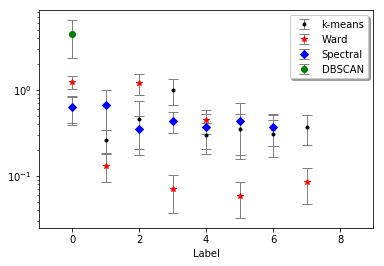

In [9]:
## Metrics of the solutions
np.random.seed(0)
labs = labels_k
qk = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_w
qw = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_s
qs = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_d
qd = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0)  

plt.yscale("log", nonposy='clip')
plt.xlim([-1,kCluster+1])
plt.errorbar(qk['label'],qk['Q'], qk['Q_err'], label='k-means',fmt='.k', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qw['label'],qw['Q'], qw['Q_err'], label='Ward', fmt='*r', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qs['label'],qs['Q'], qs['Q_err'], label='Spectral', fmt='Db', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qd['label'],qd['Q'], qd['Q_err'], label='DBSCAN', fmt='og', ecolor='gray', lw=1, capsize=5)
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Label")
plt.show()

## Angular distance (1deg) : 10.0 pc


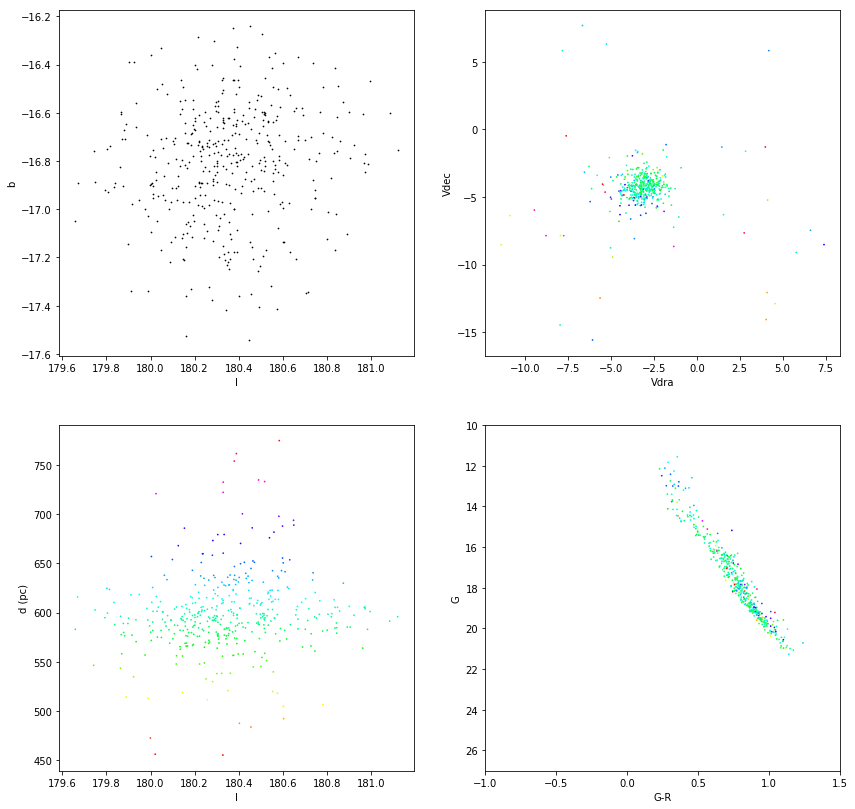

In [10]:
## separation distance
angl2pc = 3600. * 150e6 * distclust / 3.1e13
print("## Angular distance (1deg) : %3.1f pc"%(angl2pc))
plot2d(source.df, labels_d,0, cmap = "hsv")